In [1]:
# Reinstall lightgbm after environment reset
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.2 MB/s eta 0:00:0000:0100:01


Fitting 4 folds for each of 192 candidates, totalling 768 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663
[LightGBM] [Info] Number of data points in the train set: 40169, number of used features: 103
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 40169, number of used features: 103
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start

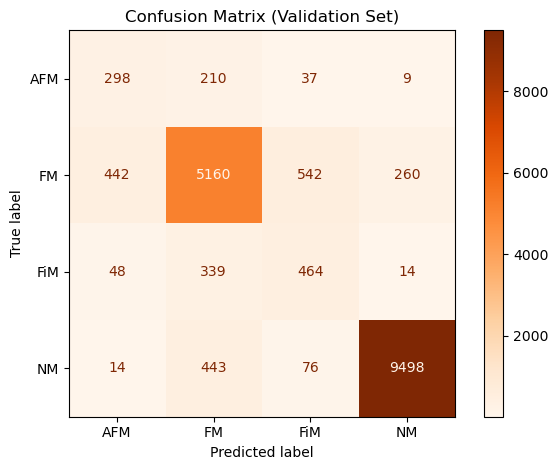

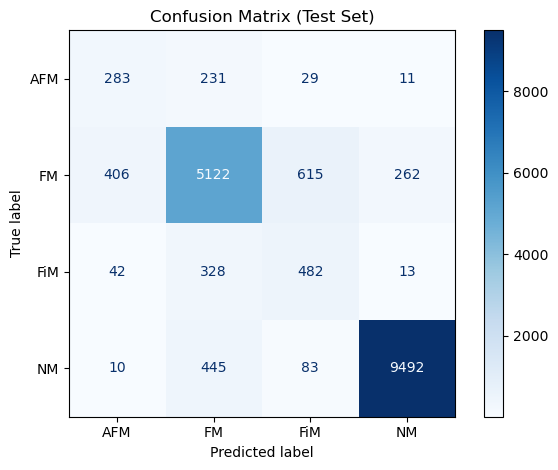

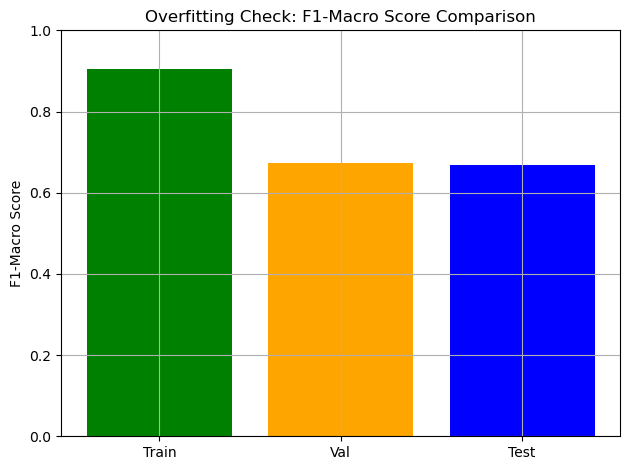

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 4016, number of used features: 91
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 9181, number of used features: 96
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start tr

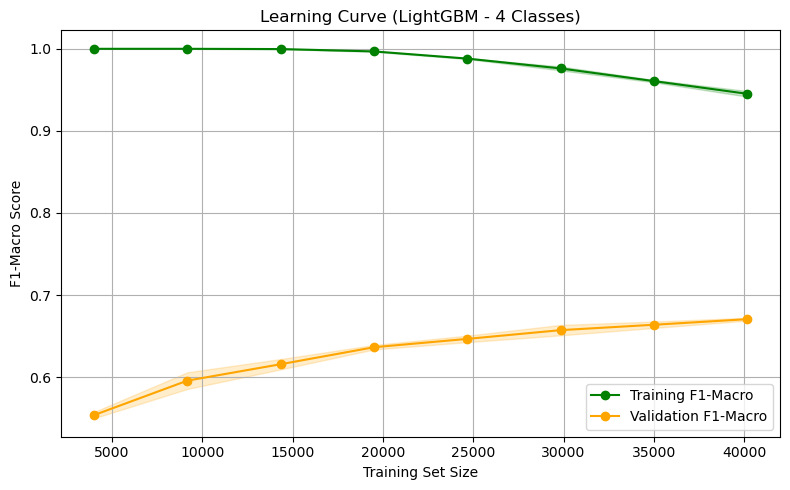

In [3]:
# Full corrected code using LightGBM for 4-class classification with hyperparameter tuning and overfitting check

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier

# === 1. Load Data ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing data ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements and crystal system ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 6. Combine features ===
X_raw = pd.concat([df[numerical_features].reset_index(drop=True),
                   element_df.reset_index(drop=True),
                   crystal_df.reset_index(drop=True)], axis=1)
X = X_raw.values

# === 7. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 8. Train/Val/Test split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 9. Hyperparameter tuning ===
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'class_weight': ['balanced']
}

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=lgbm_model,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=skf,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# === 10. Classification Reports ===
print("✅ Best Parameters:", grid_search.best_params_)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
print("\n🧪 Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# === 11. Confusion Matrices ===
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=le.classes_, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# === 12. Overfitting Check ===
f1_train = grid_search.score(X_train, y_train)
f1_val = grid_search.score(X_val, y_val)
f1_test = grid_search.score(X_test, y_test)

plt.bar(["Train", "Val", "Test"], [f1_train, f1_val, f1_test], color=["green", "orange", "blue"])
plt.ylabel("F1-Macro Score")
plt.title("Overfitting Check: F1-Macro Score Comparison")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# === 13. Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 8),
                                                       cv=skf, scoring='f1_macro', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training F1-Macro", color="green")
plt.plot(train_sizes, val_mean, 'o-', label="Validation F1-Macro", color="orange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="green")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (LightGBM - 4 Classes)")
plt.xlabel("Training Set Size")
plt.ylabel("F1-Macro Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'class_weight': 'balanced', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}


Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2663
[LightGBM] [Info] Number of data points in the train set: 40169, number of used features: 103
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 40169, number of used features: 103
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start tra

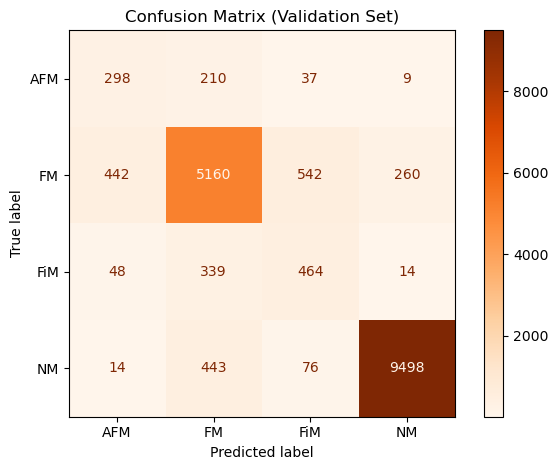

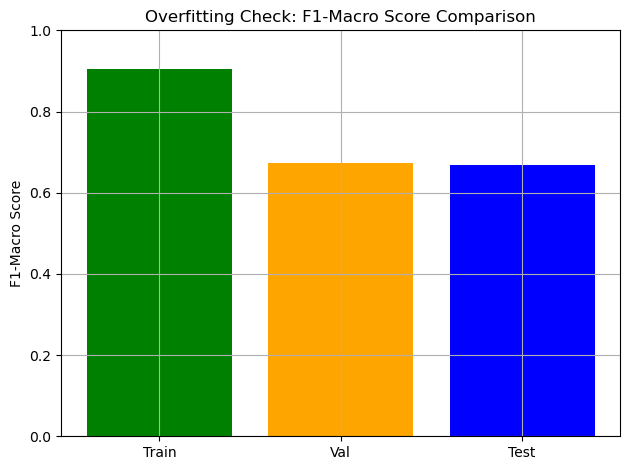

In [2]:
# Re-run the model with the best parameters

# Full corrected code using LightGBM for 4-class classification with hyperparameter tuning and overfitting check

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier

# === 1. Load Data ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing data ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements and crystal system ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 6. Combine features ===
X_raw = pd.concat([df[numerical_features].reset_index(drop=True),
                   element_df.reset_index(drop=True),
                   crystal_df.reset_index(drop=True)], axis=1)
X = X_raw.values

# === 7. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 8. Train/Val/Test split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 9. Hyperparameter tuning ===
param_grid = {
    'num_leaves': [63],
    'max_depth': [-1],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'class_weight': ['balanced']
}

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=lgbm_model,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=skf,
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# === 10. Classification Reports ===
print("✅ Best Parameters:", grid_search.best_params_)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
print("\n🧪 Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# === 11. Confusion Matrices ===
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()



# === 12. Overfitting Check ===
f1_train = grid_search.score(X_train, y_train)
f1_val = grid_search.score(X_val, y_val)
f1_test = grid_search.score(X_test, y_test)

plt.bar(["Train", "Val", "Test"], [f1_train, f1_val, f1_test], color=["green", "orange", "blue"])
plt.ylabel("F1-Macro Score")
plt.title("Overfitting Check: F1-Macro Score Comparison")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()




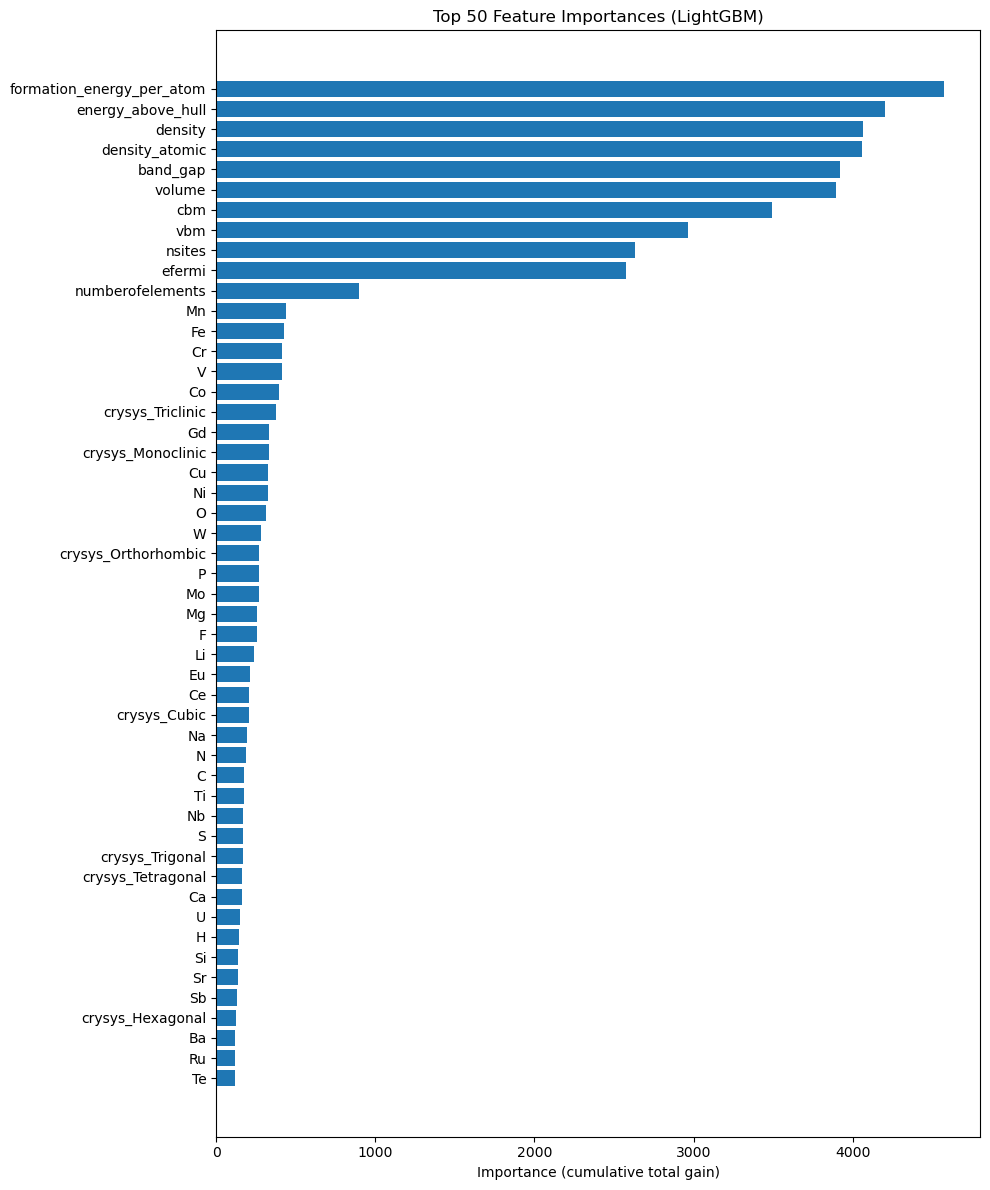

In [8]:
# === 13. Feature Importance ===
importances = best_model.feature_importances_
feature_names = X_raw.columns

# Create a DataFrame with features and their importances
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 50 features
top_n = 50
plt.figure(figsize=(10, 12))
plt.barh(feature_importance_df["Feature"].iloc[:top_n][::-1],
         feature_importance_df["Importance"].iloc[:top_n][::-1])
plt.xlabel("Importance (cumulative total gain)")
plt.title(f"Top {top_n} Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


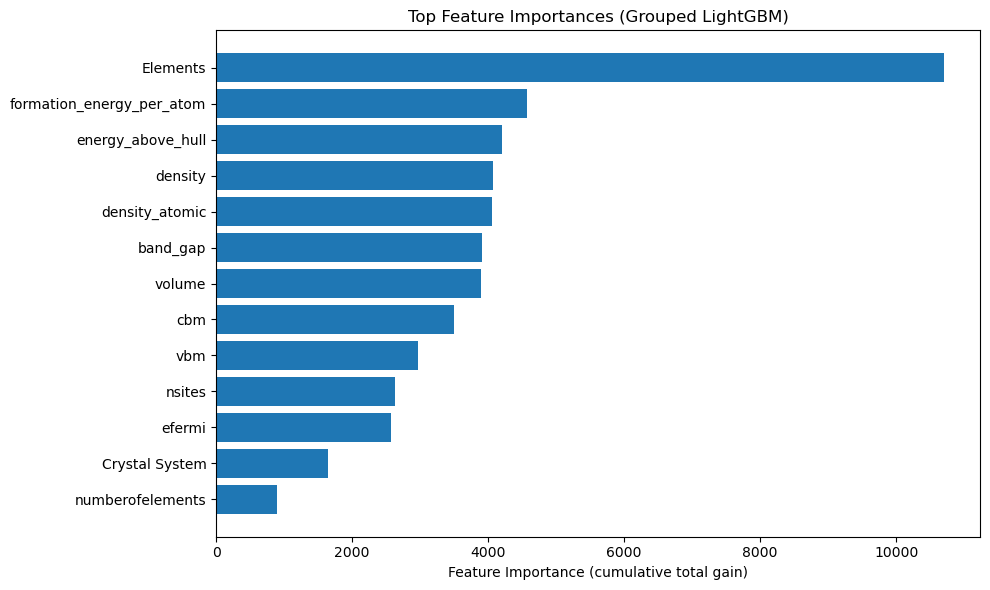

In [9]:
# === Grouped Feature Importances (LightGBM) ===

import matplotlib.pyplot as plt
import numpy as np

# Get original feature names and importances
importances = best_model.feature_importances_
feature_names = X_raw.columns

# Prepare groups
numerical_feats = set(numerical_features)
element_feats = set(mlb.classes_)
crystal_feats = set(crystal_df.columns)

grouped_names = []
grouped_values = []

# Aggregate importances
elements_importance = 0
crystal_importance = 0

for feat, imp in zip(feature_names, importances):
    if feat in numerical_feats:
        grouped_names.append(feat)
        grouped_values.append(imp)
    elif feat in element_feats:
        elements_importance += imp
    elif feat in crystal_feats:
        crystal_importance += imp

# Append grouped ones at the end
grouped_names.extend(["Elements", "Crystal System"])
grouped_values.extend([elements_importance, crystal_importance])

# Sort for plotting
sorted_indices = np.argsort(grouped_values)[::-1]
sorted_names = [grouped_names[i] for i in sorted_indices]
sorted_values = [grouped_values[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:30][::-1], sorted_values[:30][::-1])  # top 30
plt.xlabel("Feature Importance (cumulative total gain)")
plt.title("Top Feature Importances (Grouped LightGBM)")
plt.tight_layout()
plt.show()
